#  Exploring the relative significance of various health factors in determining the presence of Heart Disease

## Introduction

The term "Heart Disease" refers to different types of heart conditions, with the most common being Coronary Artery Disease (CAD), which limits bloodflow to the heart and can cause heart attacks.  High blood pressure and high blood cholesterol levels are primary risk factors for heart disease. Blood pressure, when too high, can put stress on the arteries in addition to organs such as the heart and kidneys. Cholesterol is a waxy, fat-like substance that can build up on the walls of the arteries and reduce blood flow to the heart. Resting heart rate is also a general measure of heart health, with lower heart rates indicating more efficient heart function. These variables can be accounted for and managed with the help of medications or lifestyle changes and are thus worth studying as predictors of heart disease. 

We will be trying to find which of these variables has the greatest correlation to the presence of heart disease. This will allow us to determine which factor is most important for someone to reduce their risk for heart disease. 

To do this we are using the Heart Disease Dataset which contains databases for four locations: Cleveland, Hungary, Switzerland, and the VA Long Beach. For our project we will be using the Cleveland database. Each database contains variables such as sex, age, cholesterol, blood pressure, fasting blood sugar, maximum heart rate and chest pain, and more. 


## Preliminary Exploratory Data Analysis

We begin by reading our data in from the web. Then we cleaned and wrangled it so that it is clear and easier to manipulate.

In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
# Load in libaries

#Set URL of dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

#Set file path of dataset
file_path <- "processed.cleveland.data"

#Get character vector of Column Names of Dataset
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target")

#Download dataset into R
download.file(url, destfile = file_path, method = "auto")

#Read dataset into heart_csv
heart_csv <- read_delim("processed.cleveland.data", delim = ",", col_names = column_names)

#Clean dataset
heart_data <- heart_csv |>
    select(age, sex, chol, trestbps, target) |>
    mutate(target = as_factor(ifelse(target > 0, "have heart disease", "no heart disease"))) |>
    mutate(sex = (ifelse(sex == 0, "female", "male")))
heart_data

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

age,sex,chol,trestbps,target
<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,male,233,145,no heart disease
67,male,286,160,have heart disease
67,male,229,120,have heart disease
37,male,250,130,no heart disease
41,female,204,130,no heart disease
56,male,236,120,no heart disease
62,female,268,140,have heart disease
57,female,354,120,no heart disease
63,male,254,130,have heart disease


## Training and Testing Data

In [2]:
#Create training and testing split for dataset
heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

## Summary of Data
We summarized the mean cholesteral and resting blood pressure (on admission to the hospital). This was also sorted into whether the patient had a diagnosis of heart disease.

In [3]:
#Create summary dataset 
summary_heart <- heart_train |>
    group_by(target) |>
    summarize(mean_chol = mean(chol, na.rm = TRUE), mean_trestbps = mean(trestbps, na.rm = TRUE))
    
summary_heart

target,mean_chol,mean_trestbps
<fct>,<dbl>,<dbl>
no heart disease,240.9675,129.9024
have heart disease,252.9904,134.2404


## Training Data Visualization
Plot age vs heart disease, decide to cut off at some age.



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


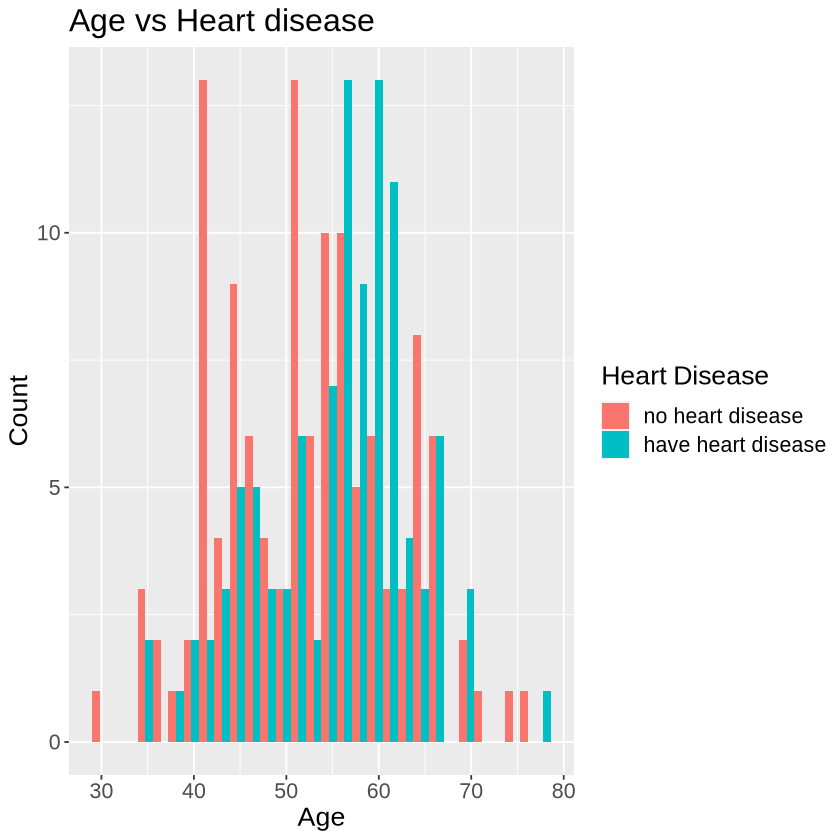

In [4]:
age_histogram <-   ggplot(heart_train, aes(x = age, fill = target)) +
                     geom_histogram(position = 'dodge') +
                     labs(x = "Age", y = "Count", fill = "Heart Disease") +
                     ggtitle("Age vs Heart disease") +
                     theme(text=element_text(size=16))
age_histogram

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


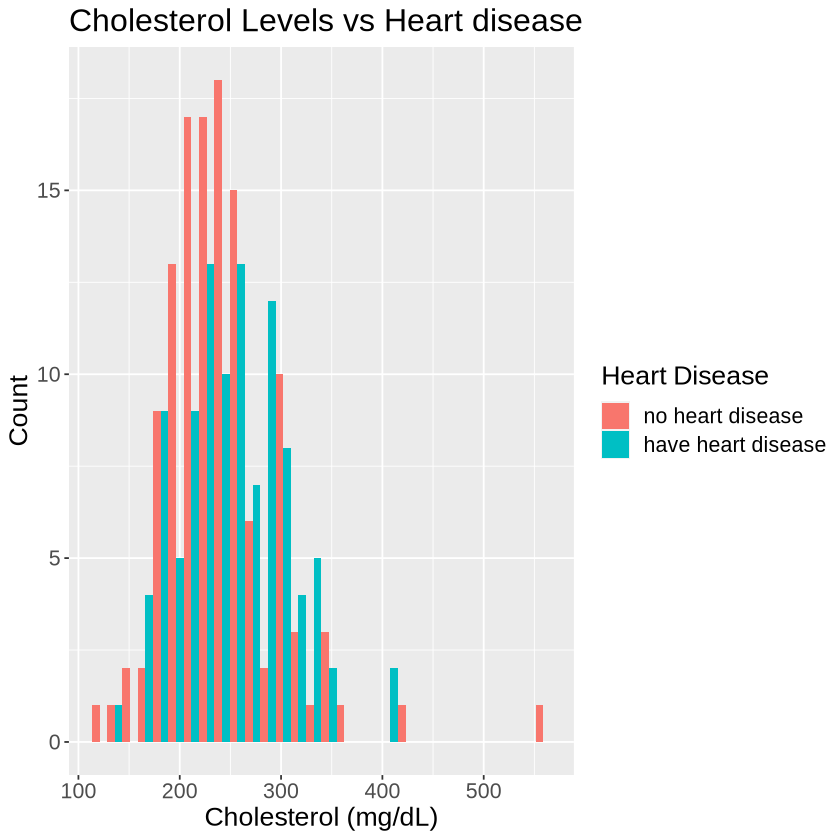

In [5]:
chol_histogram <-   ggplot(heart_train, aes(x = chol, fill = target)) +
                     geom_histogram(position = 'dodge') +
                     labs(x = "Cholesterol (mg/dL)", y = "Count", fill = "Heart Disease") +
                     ggtitle("Cholesterol Levels vs Heart disease") +
                     theme(text=element_text(size=16))
chol_histogram

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


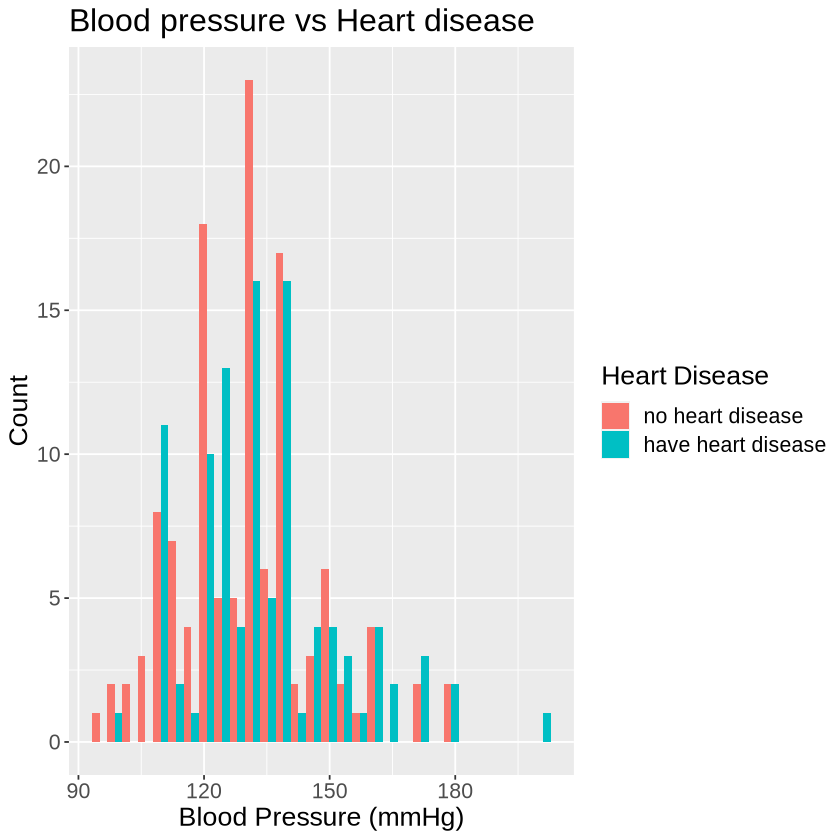

In [6]:
trestbps_histogram <-   ggplot(heart_train, aes(x = trestbps, fill = target)) +
                        geom_histogram(position = 'dodge') +
                        labs(x = "Blood Pressure (mmHg)", y = "Count", fill = "Heart Disease") +
                        ggtitle("Blood pressure vs Heart disease") +
                        theme(text=element_text(size=16))
trestbps_histogram

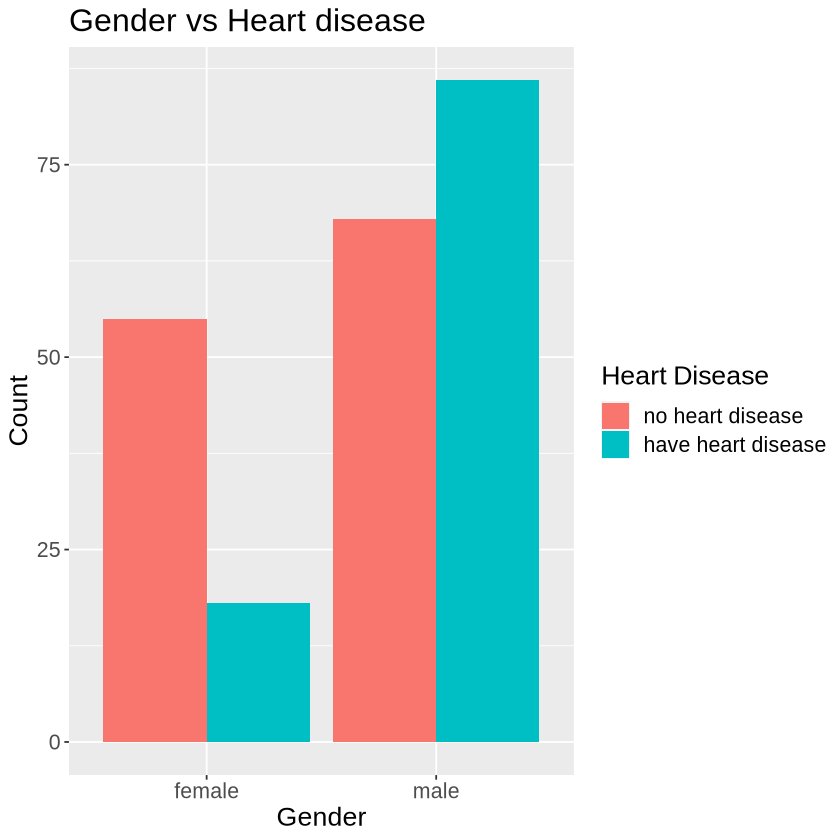

In [7]:
gender_bar <-   ggplot(heart_train, aes(x = sex, fill = target)) +
                geom_bar(position = 'dodge') +
                labs(x = "Gender", y = "Count", fill = "Heart Disease") +
                ggtitle("Gender vs Heart disease") +
                theme(text=element_text(size=16))
gender_bar

## Methods

### Variables Used
We will make the data set smaller and more manageable by using the cholesterol, resting heart rate, blood pressure, age, and sex variables. We will also keep the column that determines whether or not the patient received a diagnosis of heart disease in order to train and then test our model. 
### Data Analysis
After cleaning the data and retaining columns for each of our variables, we will split the dataset by sex. We will perform a classification using each variable for one sex and compare the accuracies of each model for that sex. Each classification will start with a training dataset that will be used to create a recipe. We will perform 5-fold cross-validation on the training set in order to find the best k value. Then, we'll build a model using that k value and the training dataset. Finally, we'll use that model to pass the testing dataset through and evaluate its' accuracy. This process will be repeated for each variable for males and then each variable for females.
### Data Visualization
We will visualize results with bar plots that represent the accuracy of each variable, separated by sex. This will demonstrate which variables are best at predicting a diagnosis of heart disease and highlight any discrepancies between sexes. Additionally, we will have confusion matrixes for each variable. We will also have tibbles with each variables' accuracy for each sex. 



## Expected outcomes and significance

### What do you expect to find? 
We expect to find that high cholesterol, high blood pressure, and increased resting heart rate are all positively correlated to a diagnosis of heart disease. We expect to find that cholesterol is the best predictor of heart disease and heart rate is the worst predictor in both sexes.
### What impact could such findings have?
Identifying the best predictor of heart disease also identifies the variable that is most important to change. So, if cholesterol is the best predictor, then one should focus on lowering their cholesterol before worrying about the other variables. 
### What future questions could this lead to?
This could lead to questions about how our diets and lifestyles can be changed to reduce these levels. Additionally, we could wonder if more resources and energy should be targeted toward the identification and treatment of some variables over others. We also may wonder if there are additional variables that we didn't include in our analysis that could have more of an impact over the variables that we chose to inspect.